### 그래프 한글 안 깨지게 하는 코드

In [3]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths='/content/drive/MyDrive/Pal-ette/D2Coding')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rc('font', family='D2Coding')

### 모듈 불러오기


In [ ]:
!pip install split-folders


In [5]:
import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, AveragePooling2D, concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

import splitfolders


### 데이터 압축풀기

In [6]:
!unzip -q "/content/drive/MyDrive/CV_project/data/안구질환/개_안구_squared.zip"


In [7]:
splitfolders.ratio('/content/개_안구_squared', output='개_train_test_val_squared', ratio=(0.8, 0.1, 0.1))  # train/val/test = 8:1:1


Copying files: 109885 files [00:14, 7461.68 files/s]


In [8]:
# prompt: /content/개_train_test_val_squared  경로의 파일을 /content/drive/MyDrive/CV_project/data/안구질환 이 경로의 드라이브에 저장하는 코드 알려줘

!cp -a /content/개_train_test_val_squared /content/drive/MyDrive/CV_project/data/안구질환


### 하이퍼파라미터 설정



In [9]:
batch_size = 32
img_size = 224
learning_rate = 5e-4
epochs = 20


classes_labels= [
    '유루증',
    '핵경화',
    '안검종양',
    '안검염',
    '정상',
    '백내장',
    '비궤양성각막질환',
    '결막염',
    '색소침착성각막염',
    '안검내반증'
]

num_classes = len(classes_labels)
base_dir = '/content/개_train_test_val_squared'

In [10]:
# 이미지 증강이 적용된 데이터 제너레이터 선언
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. /255,    # 이미지 픽셀 값을[0,1] 범위로 정규화
    width_shift_range=0.1,      # 이미지를 수평 수직으로 100% 이동
    height_shift_range=0.1,
    zoom_range=0.1, # 이미지를 무작위로 10%까지 확대
    horizontal_flip=True,       # 이미지를 수평 방향으로 주작위로 뒤집는다
    validation_split=0.2        # 전체 데이터의 20%를 검증 데이터로 사용
)

validation_datagen = ImageDataGenerator(
    rescale=1. /255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1. /255
)

# flow_from_directory : 주어진 디렉터리 경로에서 이미지 파일을 불러와 실시간으로 데이터를 전처리하고 배치 단위로 모델에 제공하는 기능
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir,'train'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',  # 분류 유형 / 이중 분류 : binary /다중 클래스 분류: categorical
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir,'val'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',  # 분류 유형 / 이중 분류 : binary /다중 클래스 분류: categorical
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir,'test'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',  # 분류 유형 / 이중 분류 : binary /다중 클래스 분류: categorical

)


Found 70321 images belonging to 11 classes.
Found 2193 images belonging to 11 classes.
Found 10997 images belonging to 11 classes.


### 이미지 확인

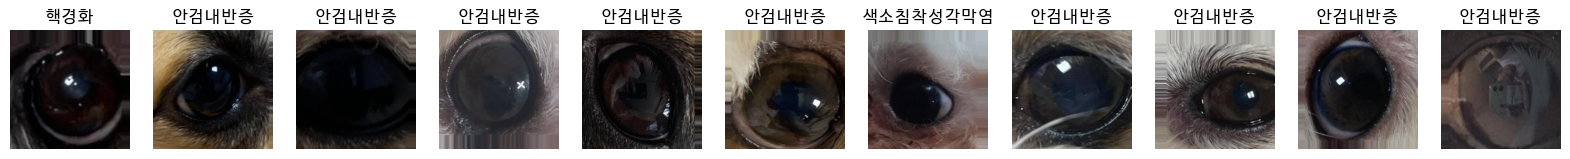

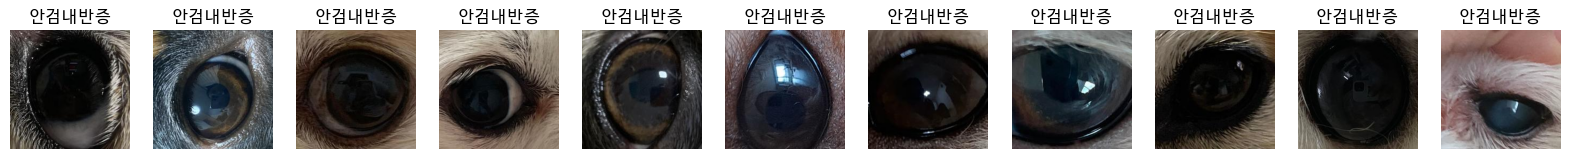

In [11]:
def show_images(generator, num_images=11):
    image, labels = next(generator)
    plt.figure(figsize=(20, 20))  # 이미지 개수에 따라 figsize 조절

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image[i])

        # 클래스 레이블에 맞는 제목 설정
        class_index = np.argmax(labels[i])  # one-hot encoded labels에서 클래스 인덱스 추출

        # Check if class_index is within the range of classes_labels
        if class_index >= len(classes_labels):
            class_index = 0

        class_name = classes_labels[class_index]
        plt.title(class_name)

        plt.axis('off')
    plt.show()

show_images(train_generator, num_images=11)  # 모든 클래스 이미지 확인
show_images(test_generator, num_images=11)

## 모델 구현
* ResNet50v2 사용


In [12]:
# 모델 불러오기 및 선언
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(img_size, img_size, 3),  # 입력 이미지 크기 (224x224x3)
    include_top=False,                    # 사전 학습된 모델의 마지막 분류 레이어 제외
    weights='imagenet',                   # ImageNet 데이터셋으로 사전 학습된 가중치 사용
    pooling='avg'                         # 특징 맵을 평균 풀링하여 1차원 벡터로 변환
)

inputs = base_model.input                 # 입력 레이어 설정 (base_model의 입력 사용)
x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)  # 128개 노드의 은닉층 추가 (ReLU 활성화 함수 사용)
x = tf.keras.layers.Dropout(0.1)(x)       # 과적합 방지를 위한 드롭아웃 레이어 추가 (10% 드롭아웃)
outputs = tf.keras.layers.Dense(11, activation='softmax')(x)  # 출력 레이어 설정 (클래스 개수만큼 출력 노드, softmax 활성화 함수 사용)

# 모델 정의
model = tf.keras.Model(inputs=inputs, outputs=outputs)  # 입력과 출력을 연결하여 모델 생성

model.summary()

94668760/94668760 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                             

### 모델 컴파일링


In [13]:
# ophtimizer 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 콜백함수
callback = [ReduceLROnPlateau(monitor='val_loss', mode = 'min', factor=0.1, patience=2, min_lr=1e-7, verbose=1),
            ModelCheckpoint('/content/drive/MyDrive/CV_project/안구질환_모델/Resnet_squared_checkpoint.tf', monitor='val_loss', mode='min', save_best_only=True)]

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## 모델 학습'


In [ ]:
histroy = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callback
)

Epoch 1/20
2198/2198 [==============================] - 788s 343ms/step - loss: 0.4986 - accuracy: 0.8220 - val_loss: 0.4345 - val_accuracy: 0.8349 - lr: 5.0000e-04
Epoch 2/20
2198/2198 [==============================] - 728s 331ms/step - loss: 0.4137 - accuracy: 0.8462 - val_loss: 0.4597 - val_accuracy: 0.8354 - lr: 5.0000e-04
Epoch 3/20
1781/2198 [=======================>......] - ETA: 2:18 - loss: 0.3838 - accuracy: 0.8539

## 평가지표


In [ ]:
# 학습 로그 출력
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), histroy.history['loss'], label='Train Loss')
plt.plot(range(epochs), histroy.history['val_loss'], label='Validation Loss')
plt.title('Traning and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.leand()

plt.plot(range(epochs), histroy.history['accuracy'], label='Train Accuracy')
plt.plot(range(epochs), histroy.history['val_accuracy'], label='Validation Accuracy')
plt.title('Traning and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
trained_model = tf.keras.models.load_model('/content/drive/MyDrive/CV_project/안구질환_모델/Resnet_squared_checkpoint.tf')

trained_model.evaluate(test_generator)